In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.postprocess import dynamic_range_nms
from utils.set_seed import seed_base

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ensemble"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ensemble']['execution']['exp_id']}"
# !rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-13 12:42:31.805481: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 12:42:31.881454: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 12:42:32.415244: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_ensemble


In [2]:
oof_xgb = pd.read_csv(f'/kaggle/output/{CFG["xgb_model"]["execution"]["best_exp_id"]}/oof.csv')
oof_xgb.head()

,series_id,step,score,event
0,038441c925bb,467,0.009440,wakeup
1,038441c925bb,467,0.001777,onset
2,038441c925bb,491,-0.034236,wakeup
3,038441c925bb,491,-0.002437,onset
4,038441c925bb,515,0.012332,wakeup


In [3]:
oof_lgb = pd.read_csv(f'/kaggle/output/{CFG["lgb_model"]["execution"]["best_exp_id"]}/oof.csv')
oof_lgb.head()

,series_id,step,score,event
0,038441c925bb,467,0.037770,wakeup
1,038441c925bb,467,-0.005550,onset
2,038441c925bb,491,0.022375,wakeup
3,038441c925bb,491,-0.007494,onset
4,038441c925bb,515,0.080513,wakeup


In [4]:
oof_gru = pd.read_parquet(f'/kaggle/output/{CFG["patch_transformer_gru"]["execution"]["best_exp_id"]}/oof.parquet')
oof_gru.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.004654,0.000332
1,05e1944c3818,18,0.003008,0.000308
2,05e1944c3818,30,0.002308,0.000296
3,05e1944c3818,42,0.001987,0.000282
4,05e1944c3818,54,0.001864,0.000265


In [5]:
oof_wave = pd.read_parquet(f'/kaggle/output/{CFG["patch_wavenet_gru"]["execution"]["best_exp_id"]}/oof.parquet')
oof_wave.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.016133,0.000098
1,05e1944c3818,18,0.014258,0.000090
2,05e1944c3818,30,0.006009,0.000092
3,05e1944c3818,42,0.005559,0.000091
4,05e1944c3818,54,0.005457,0.000100


In [6]:
oof_1d = pd.read_parquet(f'/kaggle/output/{CFG["patch_1dcnn_gru"]["execution"]["best_exp_id"]}/oof.parquet')
oof_1d.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.004375,0.000344
1,05e1944c3818,18,0.002696,0.000303
2,05e1944c3818,30,0.002196,0.000266
3,05e1944c3818,42,0.001961,0.000239
4,05e1944c3818,54,0.001900,0.000221


In [7]:
oof_tubo_based = pd.read_parquet(f'/kaggle/output/tubo_based/exp019_oof.parquet')
oof_tubo_based.head()

,series_id,step,onset_oof,wakeup_oof
0,05e1944c3818,0,0.033760,0.012846
1,05e1944c3818,1,0.026779,0.009975
2,05e1944c3818,2,0.012798,0.004220
3,05e1944c3818,3,0.005708,0.001657
4,05e1944c3818,4,0.005488,0.002279


In [8]:
dfs = []
for seires_id, df_tubo_based in tqdm(oof_tubo_based.groupby("series_id")):
    df_gru = oof_gru[oof_gru["series_id"]==seires_id]
    df_wave = oof_wave[oof_wave["series_id"]==seires_id]
    df_1d = oof_1d[oof_1d["series_id"]==seires_id]
    df_xgb = oof_xgb[oof_xgb["series_id"]==seires_id]
    df_lgb = oof_lgb[oof_lgb["series_id"]==seires_id]
    df = df_tubo_based

    # tubo based
    df["onset_oof_tubo_based"] = df["onset_oof"] / 1.5
    df["wakeup_oof_tubo_based"] = df["wakeup_oof"] / 1.5

    # gru
    df["onset_oof_gru"] = df["step"].map(df_gru.set_index("step")["onset_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    df["wakeup_oof_gru"] = df["step"].map(df_gru.set_index("step")["wakeup_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    # wave
    df["onset_oof_wave"] = df["step"].map(df_wave.set_index("step")["onset_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    df["wakeup_oof_wave"] = df["step"].map(df_wave.set_index("step")["wakeup_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    # 1d
    df["onset_oof_1d"] = df["step"].map(df_1d.set_index("step")["onset_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    df["wakeup_oof_1d"] = df["step"].map(df_1d.set_index("step")["wakeup_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    # xgb
    xgb_wakeup = df_xgb[df_xgb["event"]=="wakeup"]
    df["wakeup_oof_xgb"] = df["step"].map(xgb_wakeup.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    xgb_onset = df_xgb[df_xgb["event"]=="onset"]
    df["onset_oof_xgb"] = df["step"].map(xgb_onset.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    # lgb
    lgb_wakeup = df_lgb[df_lgb["event"]=="wakeup"]
    df["wakeup_oof_lgb"] = df["step"].map(lgb_wakeup.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    lgb_onset = df_lgb[df_lgb["event"]=="onset"]
    df["onset_oof_lgb"] = df["step"].map(lgb_onset.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    
    df["wakeup_oof"] = (
          df["wakeup_oof_gru"] * 0.17
        + df["wakeup_oof_wave"] * 0.17
        + df["wakeup_oof_1d"] * 0.17
        + df["wakeup_oof_xgb"] * 0.1 
        + df["wakeup_oof_lgb"] * 0.1
        + df["wakeup_oof_tubo_based"] * 0.3
    )
    df["onset_oof"] = (
          df["onset_oof_gru"] * 0.17
        + df["onset_oof_wave"] * 0.17
        + df["onset_oof_1d"] * 0.17
        + df["onset_oof_xgb"] * 0.1 
        + df["onset_oof_lgb"] * 0.1 
        + df["onset_oof_tubo_based"] * 0.3
    )

    # df["wakeup_oof"] = df["wakeup_oof_gru"] * 0.6 + df["wakeup_oof_xgb"] * 0.2 + df["wakeup_oof_lgb"] * 0.2 * df["wakeup_oof_tubo_based"] * 0
    # df["onset_oof"] = df["onset_oof_gru"] * 0.6 + df["onset_oof_xgb"] * 0.2 + df["onset_oof_lgb"] * 0.2 * df["onset_oof_tubo_based"] * 0

    df = df[["series_id", "step", "wakeup_oof", "onset_oof"]].reset_index(drop=True)
    dfs.append(df)
oof_df = pd.concat(dfs)
oof_df = oof_df[oof_df["step"] % 12 == 6]
oof_df.to_csv(f'{CFG["output_dir"]}/oof.csv', index=False)
del dfs
gc.collect()

100%|██████████| 277/277 [07:17<00:00,  1.58s/it]


13

2528061

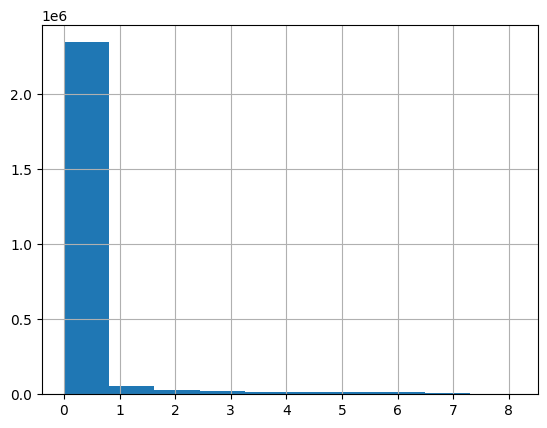

In [9]:
dfs = []
df = oof_df[["series_id", "step", "wakeup_oof"]]
df = df[df["wakeup_oof"] > 0.005]
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = oof_df[["series_id", "step", "onset_oof"]]
df = df[df["onset_oof"] > 0.005]
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs).reset_index(drop=True)
train["score"].hist()
len(train)

In [10]:
from multiprocessing import Pool

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:06<00:00, 40.79it/s]


In [11]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

score: 0.8218


event   tolerance
onset   12           0.427029
        36           0.747259
        60           0.818451
        90           0.850943
        120          0.874381
        150          0.884069
        180          0.896560
        240          0.906436
        300          0.912256
        360          0.918066
wakeup  12           0.434051
        36           0.748994
        60           0.818088
        90           0.843917
        120          0.865143
        150          0.874959
        180          0.886417
        240          0.898727
        300          0.910808
        360          0.918624
dtype: float64